# Intro

Here we'll put together a simple toy accelerator and use it to generate data so we can play around with a few machine learning algorithms. The focus here is to create a model that learns to mimic some aspects of the toy accelerator simulation. <br />


# Toy Accelerator Model

Simple longitudinal phase space example, mapping particles through a linac and then an arc. 

Produces longitudinal phase space screens for various linac phases. 


In [1]:
import numpy as np

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline 

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from math import cos, pi, sqrt

c_light = 299792458.


Make a bunch in $(z, \delta)$ space at reference energy $E_0$, where $z=-ct$ and the relative energy spread $\delta = (E-E_0)/E_0$.

In [2]:
# Simple bunch in longitudinal phase space

# z = - c t
sigma_z = 0.001; # units: meters
# delta = (E-E0)/ E0 relative energy spread
sigma_delta= .0001; # units: 1

nparticles = 1000;

# Gussian Distribution initial bunch
dist_mean = [0,0]
dist_covariance =  [[sigma_z**2, 0], [0, sigma_delta**2]]

def init_bunch(n_particles):
  return np.random.multivariate_normal(dist_mean,dist_covariance, n_particles);
bunch0 = init_bunch(nparticles)



# Bunch data
bunch0

array([[ 2.62723635e-04,  5.14003914e-05],
       [ 6.37338376e-04,  3.76097991e-05],
       [ 2.00578166e-03, -4.15069716e-05],
       ...,
       [ 1.27864326e-04, -5.57270193e-05],
       [-1.52480821e-03,  1.20805965e-04],
       [-1.12942890e-03,  8.64454137e-05]])

In [3]:
# Some statistics
def bunch_stats(bunch):
  stats = {}
  stats['z_min'], stats['delta_min'] = np.amin(bunch, 0)
  stats['z_max'], stats['delta_max'] = np.amax(bunch, 0)
  stats['sigma_z'], stats['sigma_delta'] = list(map(sqrt, np.var(bunch, 0)))
  
  return stats

bunch_stats(bunch0)

{'z_min': -0.0035153234272850497,
 'delta_min': -0.00036615880836956643,
 'z_max': 0.003246745625396384,
 'delta_max': 0.0003246038406041712,
 'sigma_z': 0.0009938474189045826,
 'sigma_delta': 9.562806056372895e-05}

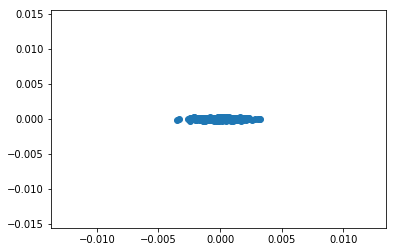

In [4]:
# Simple plot. 
plt.scatter(*bunch0.T)
plt.show()

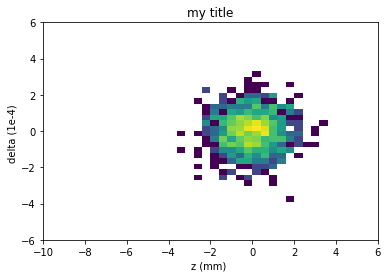

In [5]:
# Better plot

def plot_bunch(bunch, title=None, range=[(-6,6), (-6,6)]):
  x,y =bunch.T
  # colab limitations:
  #   This looks nicer on a local machine
  #   tex doesn't work: plt.rc('text', usetex=True)
  #   plt.xlabel(r'\textbf{time} (s)')
  
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xlabel('z (mm) ')
  ax.set_ylabel('delta (1e-4) ')
  if title: ax.set_title(title)
    
  ax.hist2d(1e3*x, 1e4*y, bins=40, norm=LogNorm(), range=range );
  #plt.colorbar()  
 
  return fig

  
plot_bunch(bunch0, title='my title', range=[(-10,6), (-6,6)]);

Simple Cavity map. Acceleration from energy $E_0$ to $E_1$ through a cavity with phase $\phi$, frequency $f$, and $k=2\pi f/c$.

$z \rightarrow z \\ 
\delta \rightarrow \delta \frac{E_0}{E_1} + (1- \frac{E_0}{E_1})\frac{\cos(kz +\phi)}{\cos(\phi)}$

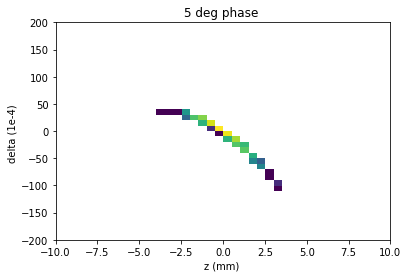

In [6]:
# Accelerate through a linac

def linac(bunch, energy0=100e6, energy1=1000e6, frf=1.3e9, phi=2*pi*(0/360)):
  """
  Simple linac (cavity) map. Accelerates from energy0 to energy1, with rf frequency frf (Hz) and phase phi (rad). 
  """
  k = 2*pi*frf/c_light
  return np.array([ (z, (1-energy0/energy1)*(cos(k*z+phi)/cos(phi) -1)+ energy0/energy1 *delta) for (z,delta) in bunch])
  

bunch1 = linac(bunch0, phi=2*pi*(5/360))
plot_bunch(bunch1, title = '5 deg phase ', range=[(-10,10), (-200,200)]);

Simple longitudinal arc map, parameterized by $r_{56}$ and $t_{566}$:

$z \rightarrow z + r_{56}\,\delta + t_{566}\,\delta^2 \\ 
\delta \rightarrow \delta$

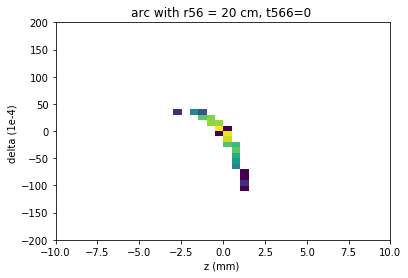

In [7]:
# Transport through an arc

def arc(bunch, r56=0, t566=0):
  """
  Simple arc with transport terms r56 and t566
  z -> z + r56*delta + t566*delta**2
  delta -> delta
  """
  return np.array([(z + r56*delta + t566*delta**2, delta) for (z, delta) in bunch])
 
bunch2 = arc(bunch1, r56 = 20e-2, t566 = 0)

plot_bunch(bunch2, title = 'arc with r56 = 20 cm, t566=0 ', range=[(-10,10), (-200,200)]);

{'z_min': -0.0011850740274346678,
 'delta_min': -0.017534271759078294,
 'z_max': 0.00011111204853735721,
 'delta_max': 0.011041656146918044,
 'sigma_z': 0.00016094864650500587,
 'sigma_delta': 0.004301508642962045}

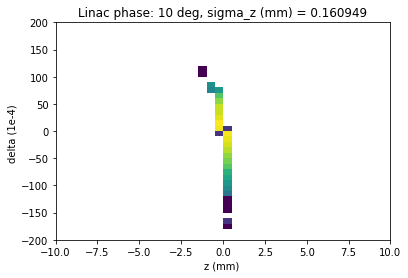

In [8]:
# Accelerator: Linac, then arc.
# Return statistics

def my_accelerator(phase_deg, energy_final = 1000e6, r56_in = 20e-2, t566_in = 1, plot_result = False):
  bunch1 = linac(bunch0, energy1 = energy_final, phi = 2*pi*(phase_deg/360))
  bunch2 = arc(bunch1, r56 = r56_in, t566 = t566_in)
  
  stats = bunch_stats(bunch2)
  sigz = '{:f}'.format(1000*stats['sigma_z'])
  
  title = 'Linac phase: '+str(phase_deg)+' deg, sigma_z (mm) = '+sigz
  if plot_result == True:
    plot_bunch(bunch2, title=title, range=[(-10,10), (-200,200)])
  
  return stats
  

mystats = my_accelerator(10, plot_result = True);
mystats

# **Regression **

Now, let's try to learn a machine model using data generated by our accelerator! 







## **1. A Few Practical Considerations and Rules of Thumb for NNs**

**1. Learning rate: **
  * Too large: will bounce around / out of minima and not converge
  * Too small: will take a very long time to converge and has less chance to find better local minima (vs. just converging to first one found)

**2. Number of layers / nodes:** 
  * Set free parameters relative to problem complexity:
    * Too many:
      * easy to overfit the data and typically makes the network generalize less well
      * training takes longer (esp. problematic for deep networks where gradient seen by earlier layers becomes very small)
    * Too few: 
      * underfitting the data
  * There are many heuristics for choosing initial number of nodes / layers (and this varies depending on architecture + amount of data available)
    * Input and output layer are just the number of inputs/outputs
    * For simple feedforward networks: some smooth transition between the number of input/output variables is often the starting point (with number of layers chosen on expected complexity of the data); e.g. 1st hidden 2/3 the input layer size + number outputs
      * e.g. linearly separable ... don't need any hidden layers
      * one hidden layer with tanh activation function --> can in theory approximate any continuous map ("universal appx theorem")
  * Automated architecture search is a less-used option (typically, starting with a small network and iterating by hand or with a small grid search can be very efficient)
 
**3. Combatting overfitting:**
  * Smaller network
  * More data
  * Regularization methods (e.g. dropout, l2 or l1 penalty on weights)
  


## **2. Generate a Data Set**

Let's generates our input/output examples.

> **X:** Accelerator input features [phase, energy, r56, t566].<br />
> **Y:** Accelerator outputs [sigma_z, sigma_delta].


Define the range of the input variables, how many samples we want, and the number of features and targets

In [9]:
num_samples = 1000 # this will be the number of training samples to use
phase_range = 100 # for 100, this will become -50 to 50 deg
energy_range = 800e6 # for 800e6 here and 500e6 for energy_min,this will become 500e6 to 1300e6
energy_min = 500e6 # this is the minimum energy to accelerate to
r56_range = 1 # for 1, this will become -0.5 to 0.5
num_features = 4
num_targets = 2

First, we want to send a variety of combinations of input variables to the accelerator. So, let's use the numpy random.rand() function to generate random values between 0 and 1 in an array that's the size of our input data (number of samples, number of input variables)

In [10]:
X = np.random.rand(num_samples, num_features) # makes an array the same size as X with random values between 0 and 1

Now our input array (X) is populated with random values between 0 and 1, but we want some realistic numbers for our accelerator. So, we'll multiply each column by the full-scale range we want the values to span and provide appropriate offsets. Then, we'll  replace the corresponding column with these new values. 

In [11]:
X[:,0]=X[:,0]*(phase_range) - phase_range/2.0  
X[:,1]=X[:,1]*(energy_range) + energy_min  
X[:,2]=X[:,2]*(r56_range) - r56_range/2.0
X[:,3]=(X[:,3] - 0.5)*0.00001 # we'll keep this small for now

Next we pre-allocate space in a separate numpy array (Y) for the output variables, using the numpy zeros((dim)) function. This generates a numpy array of the specified dimension filled only with zeros. We'll fill the array with real values in a moment.

In [12]:
Y = np.zeros((num_samples, num_targets))

Here we'll send each sample of input data to the toy accelerator function and fill the output array one sample at a time.

In [13]:
for i in range(0,num_samples):
  stats=my_accelerator(X[i,0],X[i,1],X[i,2],X[i,3])
  Y[i,0] = stats['sigma_z'] 
  Y[i,1] = stats['sigma_delta']


Let's sort these by phase so we can take a look at the data.

Text(0.5,0,'phase [deg]')

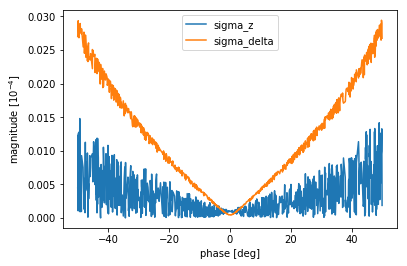

In [14]:
idx=X[:,0].argsort(kind='mergesort')
plt.plot(X[idx][:,0],Y[idx][:,0])
plt.plot(X[idx][:,0],Y[idx][:,1])
plt.legend(['sigma_z','sigma_delta'])
plt.ylabel('magnitude ' +  '$[10^{-4}]$')
plt.xlabel('phase [deg]')


## **3. Preprocessing and Separation into Training, Validation, and Testing Sets**



With raw data in hand, in order to train a ML regressor, first we'll want to **scale our data to a range that's appropriate for the algorithm we're using.** In this case, we're going to use tanh activation functions, so let's go [-1,1].



In [15]:
# scale the data from -1 to 1
X_scaled=((X-np.min(X,axis=0))*(2)/(np.max(X,axis=0)-np.min(X,axis=0)))-1
Y_scaled=((Y-np.min(Y,axis=0))*(2)/(np.max(Y,axis=0)-np.min(Y,axis=0)))-1

print('min for Y, X: ',np.min(Y_scaled,axis=0), np.min(X_scaled,axis=0))
print('max for Y, X: ',np.max(Y_scaled,axis=0), np.max(Y_scaled,axis=0))

min for Y, X:  [-1. -1.] [-1. -1. -1. -1.]
max for Y, X:  [1. 1.] [1. 1.]


Just for fun, let's also make a "challenge" set that goes outside the range of the original training set (note, this isn't a standard thing to do)

In [16]:
Yt_stretch=Y_scaled[X_scaled[:,0].argsort()]
Xt_stretch=X_scaled[X_scaled[:,0].argsort()]


X_scaled=Xt_stretch[0:Xt_stretch.shape[0]-100,:]
Y_scaled=Yt_stretch[0:Yt_stretch.shape[0]-100,:]

Yt_stretch=Yt_stretch[Yt_stretch.shape[0]-100:,:]
Xt_stretch=Xt_stretch[Xt_stretch.shape[0]-100:,:]


print('"challenge" set size: ',Xt_stretch.shape[0])

"challenge" set size:  100


Then, we need to **divide the data into training, validation, and testing sets:**
* **Training data**: This is the data that is used to update the weights. <br />
* **Validation data**: This data is not used to update the weights, but it is used during the training/model selection process to see how well a given model generalizes. This will help one decide between different ML model types to use, training algorithms to use, and sets of hyperparameters (e.g. the learning rate, the number of layers in a NN). It also is used to inform the user when the network is starting to overfit the data during training. <br />
* **Testing data**: This data is not used at all during training and is used to assess the final performance of the model.

<br />
 Often, you'll just see three sets with something like a 60% - 20% - 20% split.<br />
 But, it's good to be a little more rigorous than this and use **k-fold cross-validation**:
1. Split the training data into k segments, or "folds"
2. Train the model from scratch (i.e. with re-initialized weights) k times, holding a different fold out for validation each time
3. Use the final average error across each instance as your validation error. This will give you a better idea of how good your base model choice actually is, as opposed to just getting lucky with some of the initializations.

Here we'll just use three sets for demonstation. 


In [17]:
ints = np.random.permutation(np.arange(0,X_scaled.shape[0],1,dtype=int))

ints_train = ints[0 : np.int(X_scaled.shape[0]*0.6)]
ints_val = ints[np.int(X_scaled.shape[0]*0.6) : np.int(X_scaled.shape[0]*0.6) + np.int(X_scaled.shape[0]*0.2) ]
ints_test = ints[np.int(X_scaled.shape[0]*0.6) + np.int(X_scaled.shape[0]*0.2) : X_scaled.shape[0] ]


X_train = X_scaled[ints_train]
Y_train = Y_scaled[ints_train]
X_val = X_scaled[ints_val]
Y_val = Y_scaled[ints_val]
X_test = X_scaled[ints_test]
Y_test = Y_scaled[ints_test]

# check data set sizes
print('train size: ', X_train.shape[0])
print('val size:   ', X_val.shape[0])
print('test size:  ', X_test.shape[0])

train size:  540
val size:    180
test size:   180


Let's plot the scaled data with the challenge set removed:

Text(0.5,0,'phase')

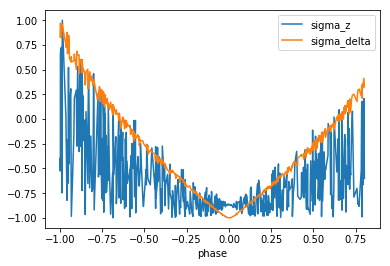

In [18]:
# sort the data into ascending phase and plot
idx = X_train[:,0].argsort(kind='mergesort')

plt.plot(X_train[idx][:,0],Y_train[idx][:,0])
plt.plot(X_train[idx][:,0],Y_train[idx][:,1])

plt.legend(['sigma_z','sigma_delta'])
plt.xlabel('phase')


Let's add some noise to the data sets:

In [19]:
multiplier = 0.05

noise1 = np.random.rand(X_train.shape[0],X_train.shape[1])*np.std(X_train,axis=0)*multiplier - np.std(X_train,axis=0)*multiplier/2.0
noise2 = np.random.rand(Y_train.shape[0],Y_train.shape[1])*np.std(Y_train,axis=0)*multiplier - np.std(Y_train,axis=0)*multiplier/2.0

X_train_noisy = X_train + noise1
Y_train_noisy = Y_train + noise2

noise1 = np.random.rand(X_val.shape[0],X_val.shape[1])*np.std(X_val,axis=0)*multiplier - np.std(X_val,axis=0)*multiplier/2.0
noise2 = np.random.rand(Y_val.shape[0],Y_val.shape[1])*np.std(Y_val,axis=0)*multiplier - np.std(Y_val,axis=0)*multiplier/2.0

X_val_noisy = X_val + noise1
Y_val_noisy = Y_val + noise2

Let's take a look at it now with noise and with the challenge set removed:

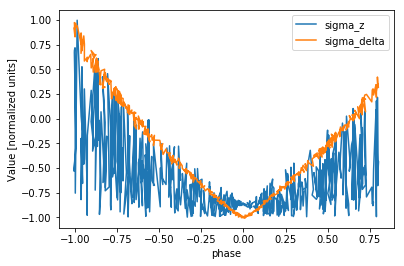

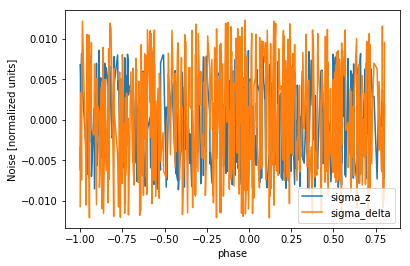

In [20]:
plt.plot(X_train_noisy[X_train[:,0].argsort(kind='mergesort')][:,0],Y_train_noisy[X_train[:,0].argsort(kind='mergesort')][:,0])
plt.plot(X_train_noisy[X_train[:,0].argsort(kind='mergesort')][:,0],Y_train_noisy[X_train[:,0].argsort(kind='mergesort')][:,1])
plt.legend(['sigma_z','sigma_delta'])
plt.xlabel('phase')
plt.ylabel('Value [normalized units]')
plt.show()

plt.plot(X_train[X_train[:,0].argsort(kind='mergesort')][:,0],Y_train[X_train[:,0].argsort(kind='mergesort')][:,0] - Y_train_noisy[X_train[:,0].argsort(kind='mergesort')][:,0] )
plt.plot(X_train[X_train[:,0].argsort(kind='mergesort')][:,0],Y_train[X_train[:,0].argsort(kind='mergesort')][:,1] - Y_train_noisy[X_train[:,0].argsort(kind='mergesort')][:,1])
plt.legend(['sigma_z','sigma_delta'])
plt.xlabel('phase')
plt.ylabel('Noise [normalized units]')
plt.show()

In [21]:
X_train = X_train_noisy
Y_train = Y_train_noisy
X_val = X_val_noisy
Y_val = Y_val_noisy

## ** 4. Now Let's Train Some Models**





<br />
### I. **Neural Networks in Keras**


Keras is a high-level library for building NNs that can run on top of Tensorflow or Theano

In [22]:
# intall keras
!pip install keras

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
# load relevant libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.models import load_model
from keras.regularizers import l2
import matplotlib.pyplot as plt

//anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### *helper functions for plotting/printing - you can ignore these*

In [24]:
# some helper functions for printing/plotting

def print_trn_val_errors(val_pred,train_pred, Y_val,Y_train):
  
  val_error=np.absolute(np.mean(val_pred-Y_val,axis=0))
  train_error=np.absolute(np.mean(train_pred-Y_train,axis=0))
  
  val_error_max=np.max(np.absolute(val_pred-Y_val),axis=0)
  train_error_max=np.max(np.absolute(train_pred-Y_train),axis=0)
  
  train_std=np.std(np.absolute(train_pred-Y_train),axis=0)
  val_std=np.std(np.absolute(val_pred-Y_val),axis=0)
  print(' ')
  print('                    ', '\033[1m'+ 'sigma_z MAE','    ','sigma_delta MAE','    ','sigma_z peak AE','       ','sigma_delta peak AE','    ','sigma_z STD AE','         ','sigma_delta STD AE')
  print('\033[1m'+'training error:    '+'\033[0m', '% 10.8f' % train_error[0], '    ', '% 10.8f'% train_error[1],'        ', '% 10.8f'% train_error_max[0],'           ', '% 10.8f'% train_error_max[1], '            ', '% 10.8f'%  train_std[0], '            ', '% 10.8f'%  train_std[1])
  print('\033[1m'+'validation error:  '+'\033[0m', '% 10.8f'% val_error[0],'    ','% 10.8f'% val_error[1],'        ', '% 10.8f'% val_error_max[0],'           ', '% 10.8f'% val_error_max[1], '            ', '% 10.8f'%  val_std[0], '            ', '% 10.8f'%  val_std[1])
  print(' ') 
  
  return

def print_error(pred, Y):
  
  error=np.absolute(np.mean(pred-Y,axis=0))
  
  error_max=np.max(np.absolute(pred-Y),axis=0)
  
  std=np.std(np.absolute(pred-Y),axis=0)
  
  print(' ')
  print('                    ', '\033[1m'+'sigma_z MAE','    ','sigma_delta MAE','    ','sigma_z peak AE','       ','sigma_delta peak AE','    ','sigma_z STD AE','         ','sigma_delta STD AE')
  print('\033[1m'+'error:             '+'\033[0m', '% 10.8f' %  error[0], '    ', '% 10.8f'%  error[1], '        ', '% 10.8f'%  error_max[0],'           ', '% 10.8f'%  error_max[1],  '            ', '% 10.8f'%  std[0], '            ', '% 10.8f'%  std[1] )
  print(' ')
  
  return

def error_plot(pred_e,Y_e,plot_text_e=' (val set shown)',show=False):
  
  error=np.absolute(pred_e-Y_e)
  
  plt.fill_between(np.arange(0,error.shape[0]), np.zeros(error.shape[0]),error)
  plt.title('Sigma_z Prediction Error \n' + str(plot_text_e))
  plt.xlabel('Sample Number')
  plt.ylabel('Sigma_z Absolute Error [norm]')
  plt.ylim(0,1.5)
  
  if show == True:
    plt.show()
    
  return

def error_plot2(X,pred_e,Y_e,plot_text_e=' (val set shown)',show=False):
  

  pred_e=pred_e[X.argsort(kind='mergesort')]
  Y_e=Y_e[X.argsort(kind='mergesort')]
  X=X[X.argsort(kind='mergesort')]


  error=np.absolute(pred_e-Y_e)
  
  plt.fill_between(X, np.zeros(error.shape[0]),error)
  plt.title('Sigma_z Prediction Error \n' + str(plot_text_e))
  plt.xlabel('Phase [norm]')
  plt.ylabel('Sigma_z Absolute Error [norm]')
  plt.ylim(0,1.5)
  
  if show == True:
    plt.show()
    
  return

def Sigma_z_plots(pred,Y,X,plot_text=' (val set shown)'):
  
  # plot simulated, predicted sigma_z
  plt.subplot(1,4,1)
  plt.plot(pred,'r',Y,'b')
  plt.title('Predicted and Simulated Sigma_z \n' + str(plot_text))
  plt.xlabel('Sample Number')
  plt.ylabel('Sigma_z [norm]')
  plt.legend(['Predicted','Actual'])

  # sigma_z error plot
  plt.subplot(1,4,2)
  error_plot(pred,Y,plot_text)
  
  # scatterplot of data and predictions for sigma_z vs phase
  plt.subplot(1,4,3)
  plt.plot(X,pred,'r.')
  plt.plot(X,Y,'b.')
  plt.title('Predicted and Simulated Sigma_z vs. Phase \n' + str(plot_text))
  plt.ylabel('Sigma_z [norm]')
  plt.xlabel('Phase [norm]')
  plt.legend(['Predicted','Actual'])
  
  # sigma_z error plot
  plt.subplot(1,4,4)
  error_plot2(X,pred,Y,plot_text)

  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.001, right=3, hspace=0.25,
                    wspace=0.35)
  plt.show()
  
  return



#### a. Initial Network


In [25]:
# build model
model_1= Sequential()
model_1.add(Dense(8, activation='tanh', input_dim=4,activity_regularizer=l2(0.00)))
model_1.add(Dense(4, activation='tanh',activity_regularizer=l2(0.00)))
model_1.add(Dense(2, activation='linear'))
model_1.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])


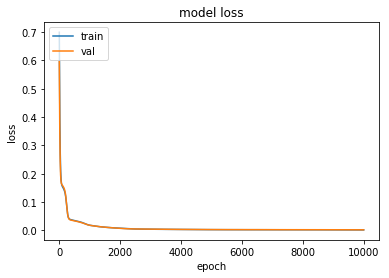

In [26]:
history = model_1.fit(X_train, Y_train,
                      validation_data=(X_val, Y_val),
                      epochs=10000,
                      batch_size=200, verbose=0)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model performance in normalized units:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
training error:      0.00006130       0.00277361           0.16329713              0.11758193               0.02948606               0.02006677
validation error:    0.00008612       0.00203054           0.18628129              0.10693099               0.03504587               0.02217030
 
 


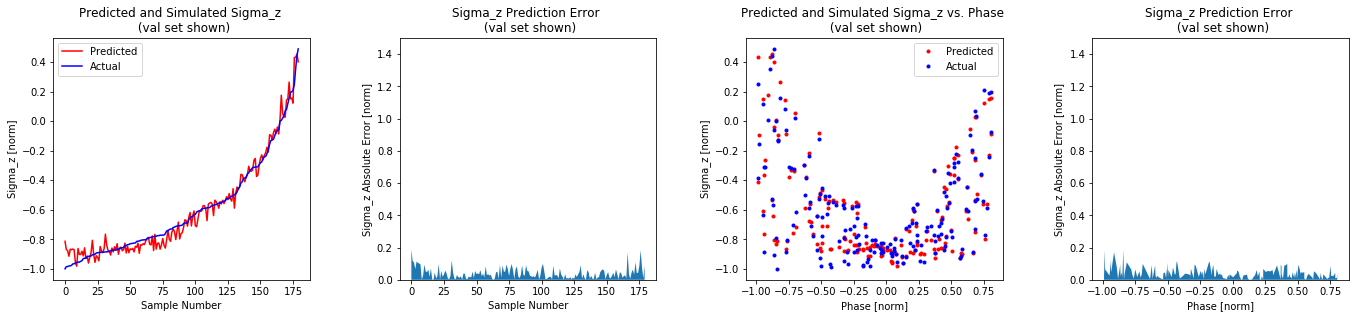

In [27]:
# predict on val and train set
val_pred = model_1.predict(X_val)
train_pred = model_1.predict(X_train)

# compute and print errors
print('model performance in normalized units:')
print(' ')
print_trn_val_errors(val_pred,train_pred,Y_val,Y_train)
print(' ')

merged=np.concatenate((X_val,Y_val),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
X_val=sort[:,0:X_val.shape[1]]
Y_val=sort[:,X_val.shape[1]:merged.shape[1]]

val_pred = model_1.predict(X_val)

# plot results
Sigma_z_plots(val_pred[:,0],Y_val[:,0],X_val[:,0])

##### -extrapolation
Now, what happens if we try to make predictions on a data set that's outside of the original training data range?

model performance on "challenge" data:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
error:               0.01391980       0.19989482           0.52720217              0.41301739               0.11501630               0.08932480
 
 


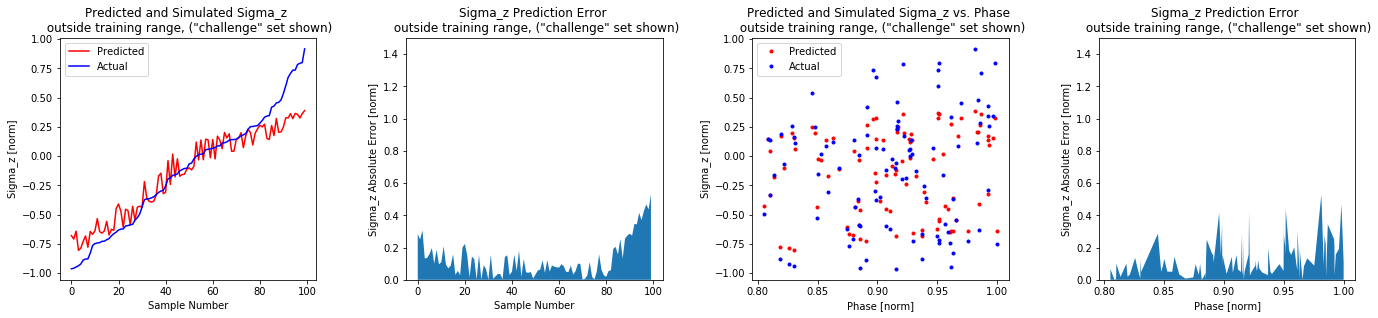

In [28]:
# predict on set
val_pred = model_1.predict(Xt_stretch)

# compute and print errors
print('model performance on "challenge" data:')
print(' ')
print_error(val_pred, Yt_stretch)
print(' ')

merged=np.concatenate((Xt_stretch,Yt_stretch),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
Xt_stretch=sort[:,0:Xt_stretch.shape[1]]
Yt_stretch=sort[:,Xt_stretch.shape[1]:merged.shape[1]]

val_pred = model_1.predict(Xt_stretch)
# plot results
Sigma_z_plots(val_pred[:,0], Yt_stretch[:,0], Xt_stretch[:,0],' outside training range, ("challenge" set shown)')


#### b. Larger Network 

If we use too many parameters (by making the network too large), it's easy to overfit the data.

In [29]:
# build model
model_2= Sequential()
model_2.add(Dense(200, activation='tanh', input_dim=4,activity_regularizer=l2(0.00)))
model_2.add(Dense(200, activation='tanh',activity_regularizer=l2(0.00)))
model_2.add(Dense(200, activation='tanh',activity_regularizer=l2(0.00)))
model_2.add(Dense(200, activation='tanh',activity_regularizer=l2(0.00)))
model_2.add(Dense(200, activation='tanh',activity_regularizer=l2(0.00)))
model_2.add(Dense(200, activation='tanh',activity_regularizer=l2(0.00)))
model_2.add(Dense(200, activation='tanh',activity_regularizer=l2(0.00)))
model_2.add(Dense(200, activation='tanh',activity_regularizer=l2(0.00)))
model_2.add(Dense(2, activation='linear'))
model_2.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])


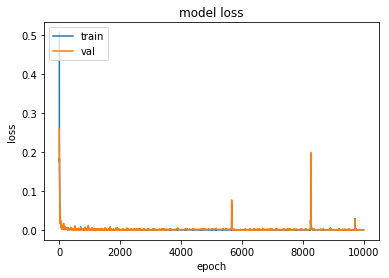

In [30]:
history = model_2.fit(X_train, Y_train,
                      validation_data=(X_val, Y_val),
                      epochs=10000,
                      batch_size=200, verbose=0)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model performance:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
training error:      0.00242992       0.00413015           0.03519226              0.04838287               0.00505407               0.00741886
validation error:    0.00168758       0.00358879           0.07426700              0.08011099               0.01174231               0.01501327
 
 


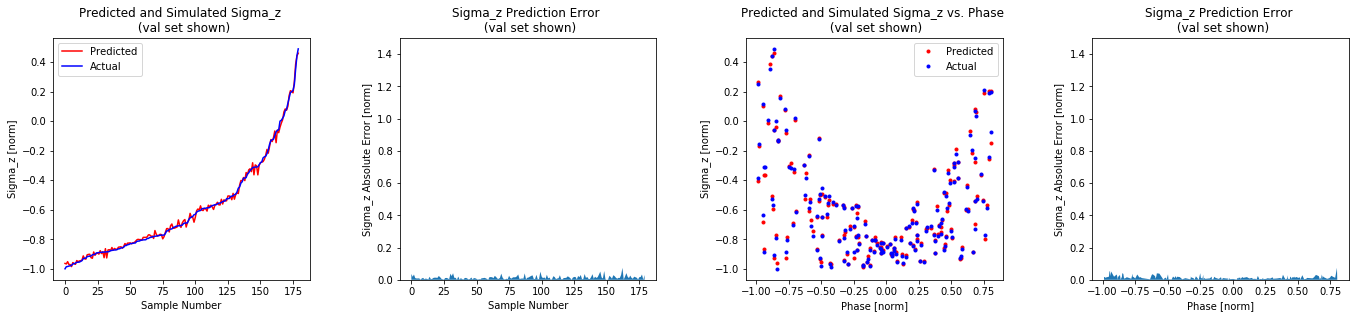

In [31]:
# predict on val and train set
val_pred = model_2.predict(X_val)
train_pred = model_2.predict(X_train)

# compute and print errors
print('model performance:')
print(' ')
print_trn_val_errors(val_pred,train_pred,Y_val,Y_train)
print(' ')


merged=np.concatenate((X_val,Y_val),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
X_val=sort[:,0:X_val.shape[1]]
Y_val=sort[:,X_val.shape[1]:merged.shape[1]]

val_pred = model_2.predict(X_val)

# plot results
Sigma_z_plots(val_pred[:,0],Y_val[:,0],X_val[:,0])

##### -extrapolation
Now, what happens if we try to make predictions on a data set that's outside of the original training data range? 

model performance on "challenge" data:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
error:               0.07883286       0.29265014           0.64506346              0.68515549               0.13061984               0.15134710
 
 


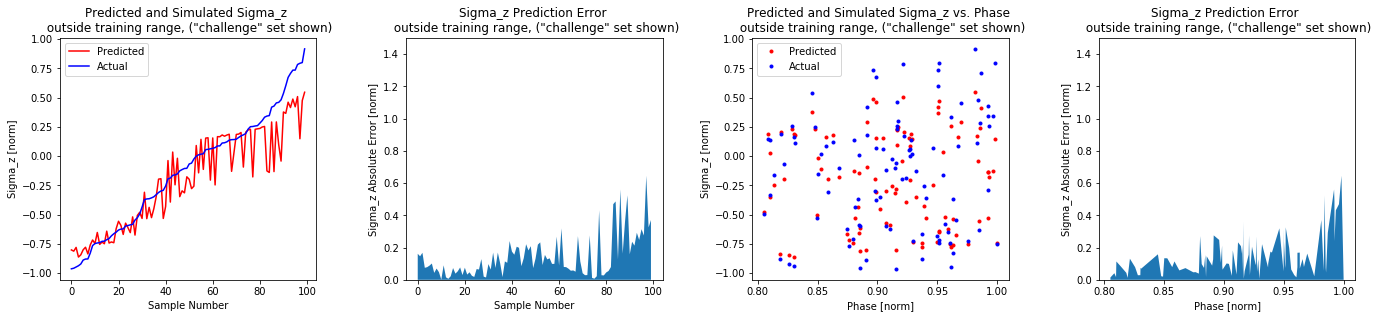

In [32]:
# predict on set
val_pred = model_2.predict(Xt_stretch)

# compute and print errors
print('model performance on "challenge" data:')
print(' ')
print_error(val_pred, Yt_stretch)
print(' ')

merged=np.concatenate((Xt_stretch,Yt_stretch),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
Xt_stretch=sort[:,0:Xt_stretch.shape[1]]
Yt_stretch=sort[:,Xt_stretch.shape[1]:merged.shape[1]]

val_pred = model_2.predict(Xt_stretch)
# plot results
Sigma_z_plots(val_pred[:,0], Yt_stretch[:,0], Xt_stretch[:,0],' outside training range, ("challenge" set shown)')


#### c. Smaller Network

If we make the network too small, we might underfit

In [33]:
# build model
model_3 = Sequential()
model_3.add(Dense(2, activation='tanh', input_dim=4,activity_regularizer=l2(0.00)))
model_3.add(Dense(2, activation='linear'))
model_3.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])


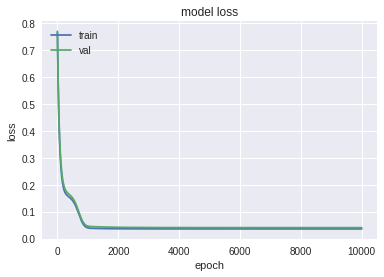

In [35]:

history = model_3.fit(X_train, Y_train,
                      validation_data=(X_val, Y_val),
                      epochs=10000,
                      batch_size=200, verbose=0)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model performance:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
training error:      0.00033329       0.00054382           0.92455096              0.21533209               0.17515718               0.03991397
validation error:    0.01396533       0.00913911           0.81195361              0.18089130               0.17927682               0.03918365
 
 


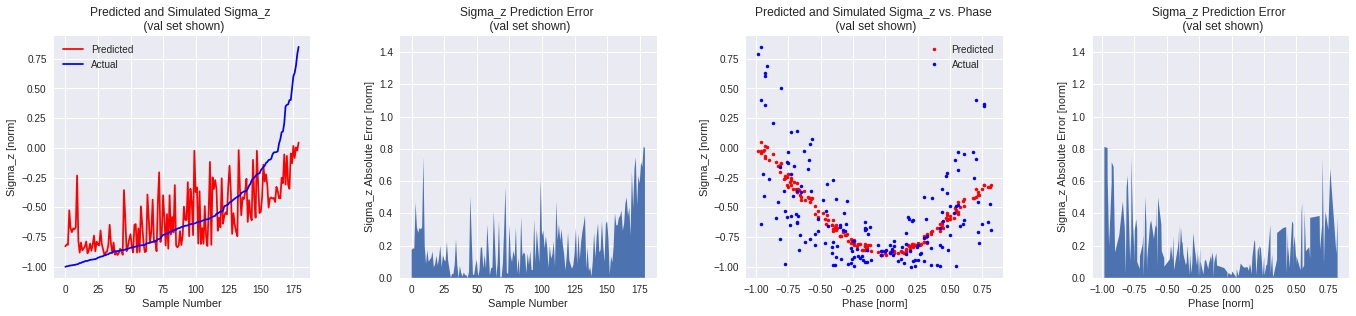

In [36]:
# predict on val and train set
val_pred = model_3.predict(X_val)
train_pred = model_3.predict(X_train)

# compute and print errors
print('model performance:')
print(' ')
print_trn_val_errors(val_pred,train_pred,Y_val,Y_train)
print(' ')


merged=np.concatenate((X_val,Y_val),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
X_val=sort[:,0:X_val.shape[1]]
Y_val=sort[:,X_val.shape[1]:merged.shape[1]]

# plot results

Sigma_z_plots(val_pred[:,0],Y_val[:,0],X_val[:,0])

##### -extrapolation
Now, what happens if we try to make predictions on a data set that's outside of the original training data range?

model performance on "challenge" data:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
error:               0.13732382       0.29418865           1.24257535              0.55460833               0.27755301               0.12843633
 
 


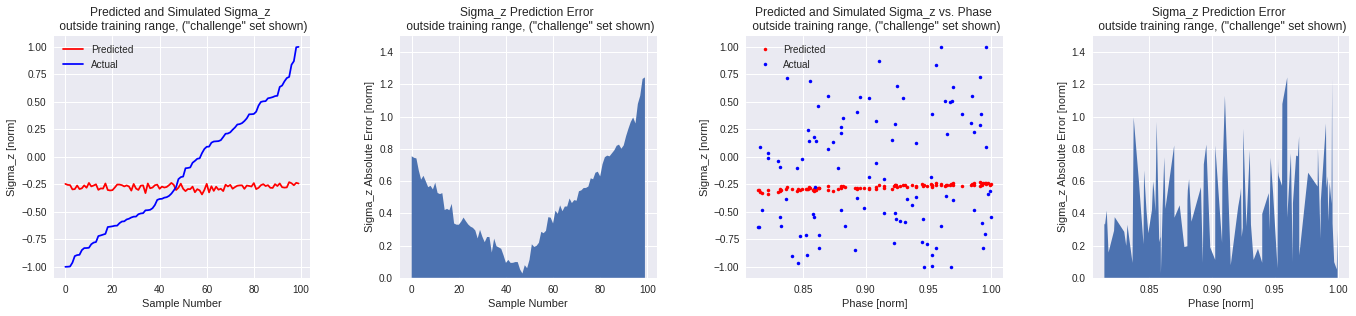

In [37]:
# predict on set
val_pred = model_3.predict(Xt_stretch)

# compute and print errors
print('model performance on "challenge" data:')
print(' ')
print_error(val_pred, Yt_stretch)
print(' ')

merged=np.concatenate((Xt_stretch,Yt_stretch),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
Xt_stretch=sort[:,0:Xt_stretch.shape[1]]
Yt_stretch=sort[:,Xt_stretch.shape[1]:merged.shape[1]]

val_pred = model_3.predict(Xt_stretch)
# plot results
Sigma_z_plots(val_pred[:,0], Yt_stretch[:,0], Xt_stretch[:,0],' outside training range, ("challenge" set shown)')


#### d. Exercises

1. Overfitting:
  * Change the number of epochs for the large network until you've stopped the training process early enough that the validation set error doesn't start to increase. This is called "early stopping" and is a way to avoid overfitting.
  
  * Change the l2 penalty from 0 to something small, like 0.001. This is a penalty on the square of the weight values and helps to avoid overfitting (this is'regularlization').
  
  * Try training with less data and with more data.

2. Noisy data: try adding different amounts of noise to the training data

3. Wider range of data: change the initial range of the data set generated, e.g. make the phase range 140 degrees

4. Try to tune the network structure and training settings to get a good combination of accuracy on the validation set and ability to generalize to the challenge data set. Evaluate this "best" network on the test set.

  
  

In [ ]:
# build model
model_4= Sequential()
model_4.add(Dense(8, activation='tanh', input_dim=4,activity_regularizer=l2(0.00)))
model_4.add(Dense(6, activation='tanh',activity_regularizer=l2(0.00)))
model_4.add(Dense(4, activation='tanh',activity_regularizer=l2(0.00)))
model_4.add(Dense(2, activation='linear'))
model_4.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])


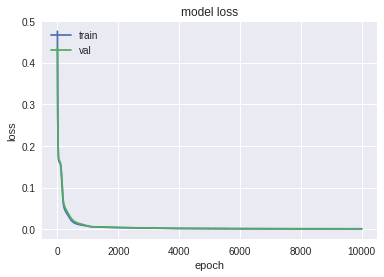

In [39]:
history = model_4.fit(X_train, Y_train,
                      validation_data=(X_val, Y_val),
                      epochs=10000,
                      batch_size=200, verbose=0)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model performance in normalized units:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
training error:      0.00199619       0.00133948           0.10810489              0.06811082               0.01820888               0.01344416
validation error:    0.00903243       0.00209830           0.19047305              0.06537555               0.02902418               0.01459840
 
 


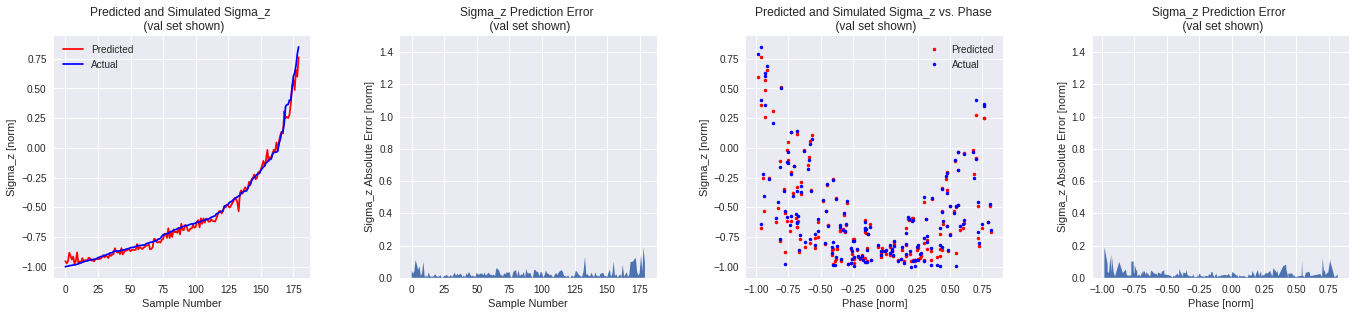

In [40]:
# predict on val and train set
val_pred = model_4.predict(X_val)
train_pred = model_4.predict(X_train)

# compute and print errors
print('model performance in normalized units:')
print(' ')
print_trn_val_errors(val_pred,train_pred,Y_val,Y_train)
print(' ')

merged=np.concatenate((X_val,Y_val),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
X_val=sort[:,0:X_val.shape[1]]
Y_val=sort[:,X_val.shape[1]:merged.shape[1]]

val_pred = model_4.predict(X_val)

# plot results
Sigma_z_plots(val_pred[:,0],Y_val[:,0],X_val[:,0])


Extrapolation: now, what happens if we try to make predictions on a data set that's outside of the original training data range?

model performance on "challenge" data:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
error:               0.05416087       0.19331993           0.61409836              0.43033051               0.13323838               0.10389920
 
 


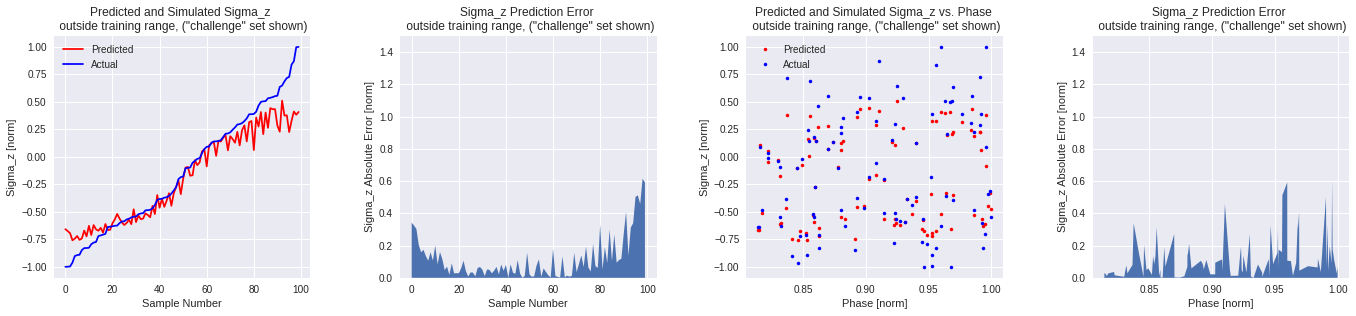

In [41]:
# predict on set
val_pred = model_4.predict(Xt_stretch)

# compute and print errors
print('model performance on "challenge" data:')
print(' ')
print_error(val_pred, Yt_stretch)
print(' ')

merged=np.concatenate((Xt_stretch,Yt_stretch),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
Xt_stretch=sort[:,0:Xt_stretch.shape[1]]
Yt_stretch=sort[:,Xt_stretch.shape[1]:merged.shape[1]]

val_pred = model_4.predict(Xt_stretch)
# plot results
Sigma_z_plots(val_pred[:,0], Yt_stretch[:,0], Xt_stretch[:,0],' outside training range, ("challenge" set shown)')
